#**SMS Spam Detection using Machine Learning**

This notebooks explores the implementation of machine learning techniques to build a classifier for SMS spam detection. The goal is to distinguish between legitimate messages (ham) and spam messages based on their content. For this purpose, the **SMS Spam Colletion** dataset is used, which contains 5,574 labeled SMS messages.

##**The dataset**

###**Description**

The SMS Spam Collection v.1 is a labeled dataset of 5,574 SMS messages in English, designed for research on SMS spam detection. Each message is categorized as either:
- **Ham** (legitimate message): 4,827 messages (86.6%).
- **Spam** (unsolicited or fraudulent messages): 747 messages (13.4%).

###**Compilation**

The dataset was curated from various publicly available sources, includin:
- Grumbletext: A UK forum where users reported spam messages, yielding 425 manually extracted spam SMS messages.
- Caroline Tag's PhD Thesis: A source of 450 ham messages.
- NUS SMS Corpus (NSC): A research dataset from the National University of Singapore, contributing 3,375 ham messages.
- SMS Spam Corpus v.0.1 Big: A collection by José María Gómez Hidalgo, providing 1,002 ham and 322 spam messages.

###**Format**
The dataset is stored as a text file, with one message per line. Each line has two columns:
1. **Label**: Either "ham" or "spam"
2. **Message text**: The raw content of the SMS.

- Link to the dataset: https://archive.ics.uci.edu/dataset/228/sms+spam+collection

##**Exploration and Data Preparation**

Getting the dataset:

In [24]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/ML Projects/Spam Detection/SMSSpamCollection'
data = pd.read_csv(file_path, sep="\t", header=None, names=["label", "message"])

# Preview the data
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


###Basic exploration

Let's see the class distribution

In [25]:
data['label'].value_counts()

,count
label,
ham,4825
spam,747


86% of the messages are legitimate and 14% are spam.

Now, it would be interesting to see common words in spam messages:

In [26]:
# Filter spam messages
spam_messages = data[data['label'] == 'spam']['message']

spam_messages.head(3)

,message
2,Free entry in 2 a wkly comp to win FA Cup fina...
5,FreeMsg Hey there darling it's been 3 week's n...
8,WINNER!! As a valued network customer you have...


In [27]:
import string
from collections import Counter
from nltk.corpus import stopwords
import nltk

In [ ]:
nltk.download('stopwords')

In [29]:
# Define stopwords and punctuation
stop_words = set(stopwords.words('english'))
punctuation = string.punctuation

In [30]:
# Tokenize, clean, and flatten all spam messages
spam_words = []
for message in spam_messages:
    # Lowercase and remove punctuations
    words = message \
        .lower() \
        .translate(str.maketrans('', '', punctuation)) \
        .split()
    # Remove stopwrods and collect words
    spam_words.extend([
        word for word in words
        if word not in stop_words and
        not word.isdigit()])

In [31]:
# Count word frequencies
word_counts = Counter(spam_words)

# Display the 10 most common words
most_common_words = word_counts.most_common(10)
print(most_common_words)

[('call', 347), ('free', 216), ('txt', 150), ('u', 147), ('ur', 144), ('mobile', 123), ('text', 120), ('stop', 115), ('claim', 113), ('reply', 101)]


**CALL!!** **FREE!!** **CLAIM!!** **REPLY!!**

<div>
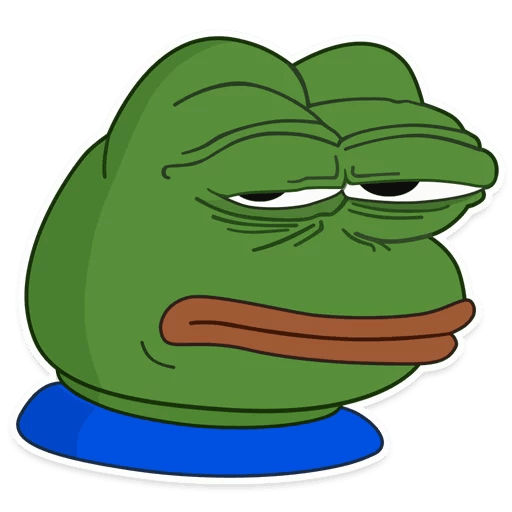
</div>

Let's visualize it in a bar plot

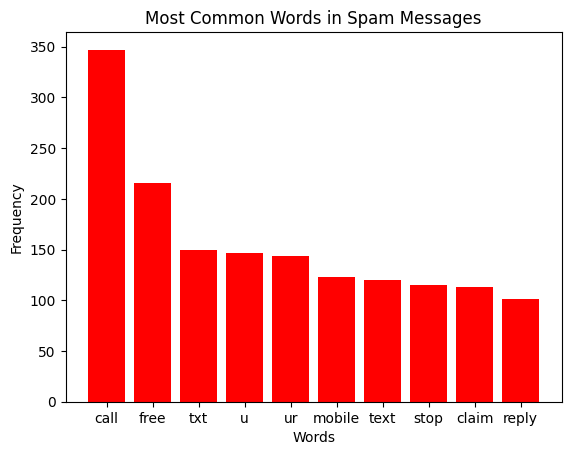

In [32]:
import matplotlib.pyplot as plt

# Prepare data for plotting
words, counts = zip(*most_common_words)

# Plot
plt.bar(words, counts, color='red')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Common Words in Spam Messages')
plt.show()

This gives us an idea of which words are most important to consider a message as spam. We will explore this further later.

###Cleaning the data

*   Remove special characters
*   All words to lower case
*   Remove stopwords

Removing special characters can be beneficial for several reasons: normalization of the text data, reducing noise, feature reduction, consistency, etc. But removing special characters will strip out punctuation and symbols, and if not done carefully, it could affect numbers and URLs, which are often key indicators of spam messages. The same could apply for emails, hashtags, etc.

-   Numbers are characteristics in spam messages, often appearing in contexts like prices, dates, percentages, or contact numbers ("Win $1000 today!", "50% off", "Call 1-800-XXX-XXXX").
    -   Instead of removing numbers, I will normalize them. For instance, all numbers could be replaced with a placeholder like "NUMBER".
-   URLs are commonly used in spam SMS for phishing, scam offers, or directing users to malicious sites.
    -   Instead of removing them, I will also replace them with "URL".

In [33]:
import re
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')

In [35]:
def clean_message(message):
    # Convert to lowecase
    message = message.lower()

    # Normalize URLs
    message = re.sub(r'http\S+', '<URL>', message)

    # Normalize numbers
    message = re.sub(r'\d+', '<NUMBER>', message)

    # Remove special characters except for numbers
    # and URLs which are now tokens
    message = re.sub(r'[^a-zA-Z\s<URL><NUMBER>]', '', message)

    words = word_tokenize(message)

    # Remove stopwords
    words = [
        word for word in words
        if word not in stop_words]

    # Join the words back into a string
    return ' '.join(words)

Before continuing, let's check if it does work:

In [36]:
example_data = {
    "message": [
        "Hey, check out https://example.com for more details!",
        "Win $1000 now!!! Call us at 123-456-7890 or email spammer@example.com",
        "#Giveaway Alert! Participate to win exciting prizes.",
    ]
}

for msg in example_data["message"]:
    print(clean_message(msg))

hey check < URL > details
win < NUMBER > call us < NUMBER > < NUMBER > < NUMBER > email spammerexamplecom
giveaway alert participate win exciting prizes


👌

In [37]:
# Apply the clean function to the 'message' column
data['message'] = data['message'].apply(clean_message)

Now, let's split the data into training and testing sets.

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = \
    train_test_split(
        data['message'],
        data['label'],
        test_size=0.25,
        random_state=1,
        stratify=data['label'])

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print(f'Train examples: {X_train.shape[0]}\n'
      f'Test examples: {X_test.shape[0]}')

Train examples: 4179
Test examples: 1393


Here, I used <tt>stratify=data['label']</tt> to ensure the proportion of *spam* and *ham* in both the training and testing sets is roughly the same as in the original dataset.

Lastly, I will encode the class labels

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
le = LabelEncoder()
data['label'] = le.fit_transform(data['label'])

In [42]:
data.head(3)

,label,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry < NUMBER > wkly comp win fa cup fin...


##**Text Representation**

I'll use the **TF-IDF vectorizer**. TF-IDF will help us highlight keywords characteristic of spam since it assigns higher weights to terms that are frequent in a specific message but less common across all messages. Since the target class is unbalanced, I think TF-IDF would be better thant other apporaches like **Bag of Words** because of this. On the other hand, SMS messages are short, and this make TF-IDF particularly suitable for extracting useful features without being overwhelmed by word frequency.

Anyways, I will also try **Bag of words** since it could be interesting to see the difference in the results in practice.

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer # BOW

In [44]:
tfidf_vect = TfidfVectorizer()
bow_vect = CountVectorizer()



---



##**Model Training and Evaluation**

###Logistic Regression

The first model to be tested will be **Logistic Regression**. For a binary classification problem like this, it can be quite effective.

In [45]:
from sklearn.linear_model       import LogisticRegression
from sklearn.pipeline           import Pipeline
from sklearn.model_selection    import GridSearchCV
from sklearn.metrics            import confusion_matrix, \
                                       accuracy_score, \
                                       ConfusionMatrixDisplay

In the following code I'll perform a **Corss-Validated Grid Search** to systematically explore combinations of hyperparameters and select the best configuration for the Logistic Regression model. By evaluating each combination across multiple data splits, we ensure the model's performance generalizes well on unseen data.

In [46]:
### For TF-IDF ###

lr_tfidf_param_grid = [
    {
        'vect__ngram_range':    [(1, 1), (1, 2)],
        'vect__use_idf':        [True, False],
        'vect__norm':           ['l1', 'l2'],
        'clf__penalty':         ['l2'],
        'clf__C':               [1.0, 10.0, 100.0],
        'clf__solver':          ['lbfgs', 'liblinear']
    }
]

lr_tfidf_pipe = Pipeline([
    ('vect', tfidf_vect),
    ('clf', LogisticRegression())
])

lr_tfidf_gs = GridSearchCV(lr_tfidf_pipe,
                           lr_tfidf_param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=3,
                           n_jobs=2)

About the explored parameters:
-  `vect__ngram_range`: This controls the range of the n-grams considered by the TF-IDF vectorizer.
-  `vect__use_idf`: Testing both True and False helps determine whether IDF improves performance.
-  `vect__norm`: Normalization adjusts term vectors to have unit length.
-  `clf__penalty`: Specifies the regularization technique for Logistic Regression.
-  `clf__C`: The inverse of regularization strength. Lower values (e.g., 1.0) apply stronger regularization, while higher values (e.g., 100.0) allow more flexibility.
-  `clf__solver`: Specifies the optimization algorithm for Logistic Regression.
    -  `lbfgs` is efficient for small-to-medium datasets.
    -  `liblinear` supports smaller datasets and sparse matrices, making it well-suited for text data.

In [47]:
### For BOW ###

param_grid_bow = [
    {
        'vect__ngram_range':    [(1, 1), (1, 2)],
        'vect__binary':         [True, False],
        'clf__penalty':         ['l2'],
        'clf__C':               [1.0, 10.0, 100.0],
        'clf__solver':          ['lbfgs', 'liblinear']
    }
]

lr_bow_pipe = Pipeline([
    ('vect', bow_vect),
    ('clf', LogisticRegression())
])

lr_bow_gs = GridSearchCV(lr_bow_pipe,
                         param_grid_bow,
                         scoring='accuracy',
                         cv=5,
                         verbose=3,
                         n_jobs=2)

Accuracy measures the proportion of correctly classified samples. It is intuitive, easy to compute, and provides a quick overall assessment of the model's performance. But we must take into account:
-  In datasets with class imbalance (like this one), accuracy can be misleading. I will use it only for selecting the best combination and then explore other metrics.

I'll now fit the models to the training set.

For TF-IDF:

In [ ]:
lr_tfidf_gs.fit(X_train, y_train)

In [49]:
print(f'Best parameter set: {lr_tfidf_gs.best_params_}')

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'vect__ngram_range': (1, 1), 'vect__norm': 'l2', 'vect__use_idf': True}


Average 5-fold cross validation accuracy on the training set:

In [50]:
print(f'CV Accuracy: {lr_tfidf_gs.best_score_:.3f}')

CV Accuracy: 0.983


For BOW:

In [ ]:
lr_bow_gs.fit(X_train, y_train)

In [52]:
print(f'Best parameter set: {lr_bow_gs.best_params_}')

Best parameter set: {'clf__C': 100.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'vect__binary': True, 'vect__ngram_range': (1, 1)}


Average 5-fold cross validation accuracy on the training set:

In [53]:
print(f'CV Accuracy: {lr_bow_gs.best_score_:.3f}')

CV Accuracy: 0.985


In what follows, I will analyze the cross-validation accuracy results obtained during the grid search process for Logistic Regression with TF-IDF. Cross-validation helps evaluate model performance on multiple data splits, providing insights into how the model generalizes to unseen data.

To better understand the stability of different parameter combinations, I will plot the mean accuracy and its variability (±1 standard deviation) across folds.

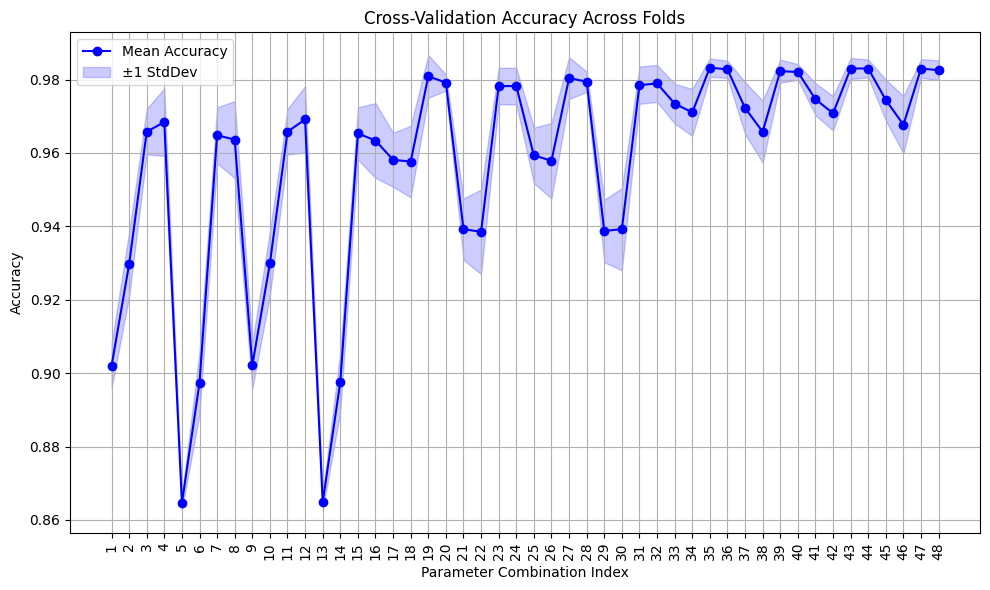

In [54]:
# Extract results from GridSearchCV
results = pd.DataFrame(lr_tfidf_gs.cv_results_)

# Get the mean and standard deviation of accuracy scores for each parameter combination
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']
x_values = range(len(mean_scores))

# Plot the accuracy variations using fill_between for a nice viewing
plt.figure(figsize=(10, 6))
plt.plot(x_values, mean_scores, marker='o', label='Mean Accuracy', color='blue')
plt.fill_between(x_values, mean_scores - std_scores, mean_scores + std_scores,
                 color='blue', alpha=0.2, label='±1 StdDev')

plt.title('Cross-Validation Accuracy Across Folds')
plt.xlabel('Parameter Combination Index')
plt.ylabel('Accuracy')
plt.xticks(x_values, labels=range(1, len(mean_scores) + 1), rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The plot illustrates the mean accuracy across folds for each parameter combination tested during grid search, represented by the blue line. The shaded region around the line visualizes the variability in accuracy across the folds.

**Some observations**:
1. Many parameter combinations exhibit minimal variability, as shown by the narrow shaded regions. These combinations are robust and perform consistently.
2. Other combinations display larger shaded regions, indicating sensitivity to the specific training split. These configurations might overfit or underfit depending on the data.
3. Combinations with high mean accuracy and small variability (e.g., 44) are ideal candidates, as they suggest both strong performance and stability.

Now it's time to **evaluate it in the test dataset**. We can get the best classificator (i.e. the logistic regression classifier with the best parameters combination encountered) via the <tt>best_estimator_</tt> parameter of the GridSearch objetct after training.

In [56]:
# Get the best classifiers
lr_clf_tfidf = lr_tfidf_gs.best_estimator_
lr_clf_bow = lr_bow_gs.best_estimator_

# Transform the test dataset using the vectorizers from the best pipelines
X_test_tfidf = lr_clf_tfidf.named_steps['vect'].transform(X_test)
X_test_bow = lr_clf_bow.named_steps['vect'].transform(X_test)

# Make predictions on the transformed test dataset
lr_clf_tfidf_pred = lr_clf_tfidf.named_steps['clf'].predict(X_test_tfidf)
lr_clf_bow_pred = lr_clf_bow.named_steps['clf'].predict(X_test_bow)

Accuracy on test:

In [57]:
print(f'LR with TF-IDF Accuracy: {accuracy_score(y_test, lr_clf_tfidf_pred):.3f}\n'
      f'LR with BOW Accuracy: {accuracy_score(y_test, lr_clf_bow_pred):.3f}')

LR with TF-IDF Accuracy: 0.981
LR with BOW Accuracy: 0.985


With BOW vectorizer, LogisticRegression got a slightly better performance regarding to accuracy. But, although accuracy is a good metric, it doesn't tell much about the performance on each class (spam or ham). So, I'm going to construct the confusion matrix for each classifier and see how they performed. But first, I'm going to show some misclasified samples and try to understand why they where misclassified.

In [58]:
import numpy as np

In [59]:
# Identify indices of misclassified messages
misclassified_indices = np.where(lr_clf_tfidf_pred != y_test)[0]

# Display some examples of misclassified messages
print("Examples of Misclassified Messages:\n")
for i in misclassified_indices[:5]:
    print(f"Message: {X_test[i]}")
    print(f"True Label: {y_test[i]} | 'Predicted Label: {lr_clf_tfidf_pred[i]}")
    print("-" * 80)

Examples of Misclassified Messages:

Message: want explicit sex < NUMBER > secs ring < NUMBER > costs < NUMBER > pmin
True Label: spam | 'Predicted Label: ham
--------------------------------------------------------------------------------
Message: v nice < NUMBER > sheffield tom < NUMBER > air opinions categories < NUMBER > b used < NUMBER > measure ethnicity next census busy transcribing
True Label: ham | 'Predicted Label: spam
--------------------------------------------------------------------------------
Message: bought one ringtone getting texts costing < NUMBER > pound offering tones etc
True Label: spam | 'Predicted Label: ham
--------------------------------------------------------------------------------
Message: please come imin towndontmatter urgoin outl < NUMBER > rjust reallyneed < NUMBER > docdplease dontplease dontignore mycallsu thecd isvimportant tome < NUMBER > < NUMBER > moro
True Label: ham | 'Predicted Label: spam
--------------------------------------------------

**Some observations**:

The model seems to have missed obvious spam messages, possible due to unfamiliar terms or insufficient weight given to certain keywords like "sex". Another reason could be that some spam messages include transactional language that overlaps with legitimate contexts.

The model also have false positives. This could be due to the inclusion of numbers, as it encounter similarities with spam patterns. Another reason could be due to words that express urgency, this is also related to spam messages, leading to misclassification.

Ok then, let's continue with the confusion matrices.

In [60]:
import seaborn as sns

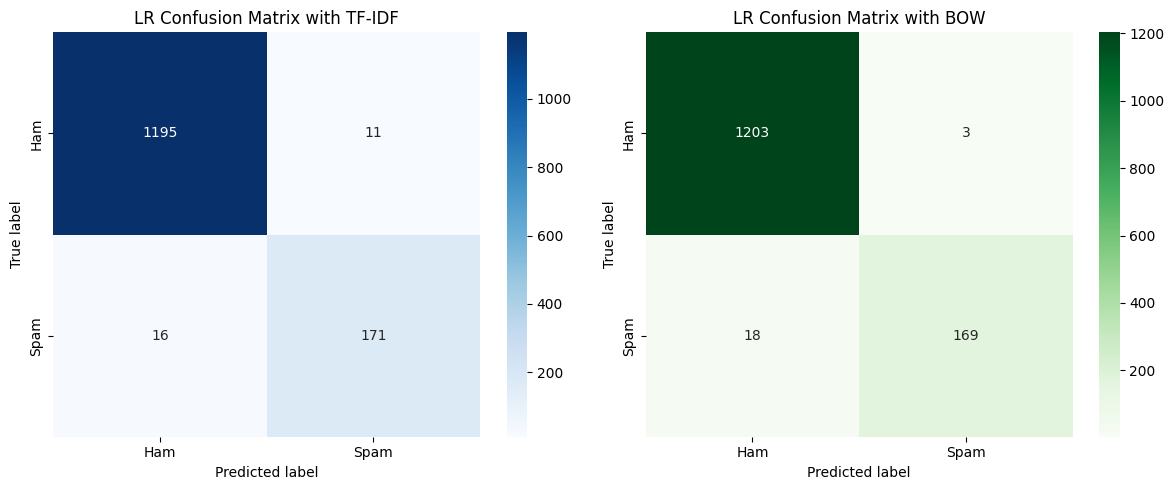

In [61]:
lr_tfidf_conf_mtx = confusion_matrix(y_test, lr_clf_tfidf_pred)
lr_bow_conf_mtx = confusion_matrix(y_test, lr_clf_bow_pred)

labels = ['Ham', 'Spam']
lr_tfidf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=lr_tfidf_conf_mtx,
                                           display_labels=labels)
lr_bow_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=lr_bow_conf_mtx,
                                         display_labels=labels)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(lr_tfidf_conf_mtx, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('LR Confusion Matrix with TF-IDF')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')
ax1.set_xticklabels(labels)
ax1.set_yticklabels(labels)

sns.heatmap(lr_bow_conf_mtx, annot=True, fmt='d', cmap='Greens', ax=ax2)
ax2.set_title('LR Confusion Matrix with BOW')
ax2.set_xlabel('Predicted label')
ax2.set_ylabel('True label')
ax2.set_xticklabels(labels)
ax2.set_yticklabels(labels)

plt.tight_layout()
plt.show()

**Interpretation**:

-  **True Positives**: Correctly identifie spam messages (171 for TF-IDF, 169 for BOW)
-  **False Positives**: Ham messages misclassified as spam (11 for TF-IDF, 3 for BOW)
-  **True Negatives**: Correctly identified ham messages (1195 for TF-IDF, 1203 for BOW).
-  **False Negatives**: Spam messages misclassified as ham (16 for TF-IDF, 18 for BOW).

**The balance matters**:

-  Misclassifying spam as ham (FN) means spam gets through to users, potentially causing annoyance or harm.
-  Misclassifying ham as spam (FP) leads to legitimate messages being blocked, degrading user experience.

**Precision and Recall of the *spam* class**:

- Precision answers the question: Of the messages that the model classified as spam, what proportion were actually spam?
- Recall answers the question: Of all the messages that were spam, what proportion did the model manage to correctly classify?

-  For TF-IDF:
$$ Precision = \frac{TP}{TP + FP} = \frac{171}{171 + 11} = 0.940 $$
    -  Of all the messages classified as spam, 94% were actually spam.
$$ Recall = \frac{TP}{TP + FN} = \frac{171}{171 + 16} = 0.914 $$
    -  Of all the actual spam messages, 91.4% were correctly identified by the model. The model has a strong ability to catch most spam messages, although a small proportion of spam messages were missed.

-  For BOW:
$$ Precision = \frac{TP}{TP + FP} = \frac{169}{169 + 3} = 0.983 $$
    -  Of all the messages classified as spam, 98.3% were actually spam. The model rarely misclassifies ham as spam.
$$ Recall = \frac{TP}{TP + FN} = \frac{169}{169 + 18} = 0.904 $$
    -  Of all the actual spam messages, 90.4% were correctly identified by the model.

BOW has a higher precision than TF-IDF, meaning it is more cautious in labeling a message as spam. This makes BOW better at avoiding false positives. On the other hand, TF-IDF has slightly recall compared to BOW, meaning TF-IDF is slightly better at identifying spam messages overall. However, the difference is small and might not be practically significant.

It is difficult to draw conclusions from such a small difference. It would be interesting to see both models with a large dataset to see how they perform. It seems that TF-IDF is more balanced between precision and recall, while BOW prioritizes precision over recall. Depending on the context one might prefer one approach over the other.

####**Feature Importance**

To gain deeper insights into how Logistic Regression identifies spam versus ham messages, let's examine the most influential words in our trained model. Logistic Regression assigns a coefficient to each feature (word or n-gram), representing its imporatnce in determining whether a message is spam or not.

By analyzing these coefficients, we can identify which words strongly indicate spam (positive coefficients) or ham (negative coefficients). In this way we can:
1. Validate the model's behavior by checking whether important words align with our expectations.
2. Gain interpretability to understanding the decisions.

In the following code I will extract these coefficients, sort them by magnitude, and plot the top 20 most influential words.

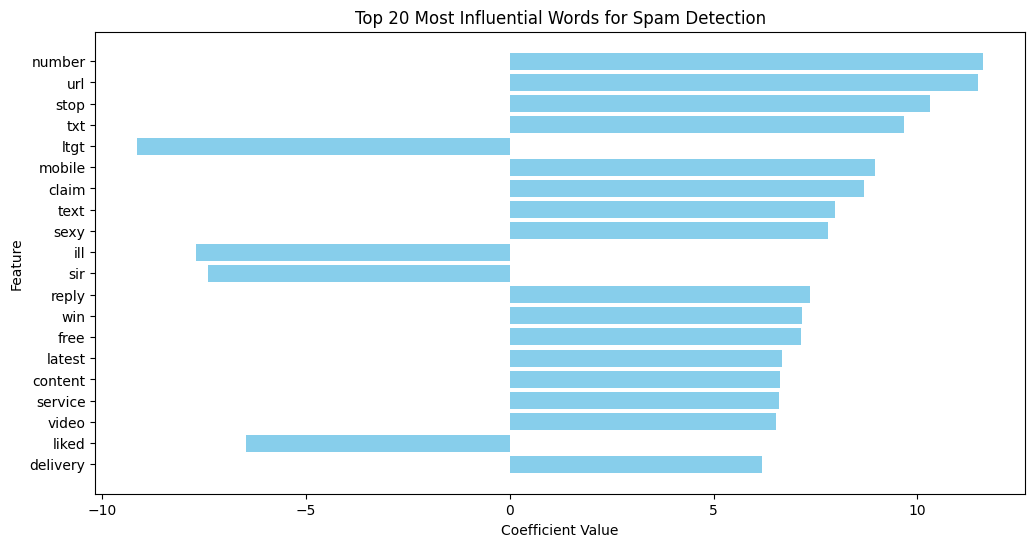

In [62]:
# Extract the best Logistic Regression model trained with TF-IDF
best_model = lr_tfidf_gs.best_estimator_
vectorizer = best_model.named_steps['vect']
classifier = best_model.named_steps['clf']

# Get feature names and coefficients
feature_names = vectorizer.get_feature_names_out()
coefficients = classifier.coef_[0]  # Coefficients for spam class

# Create a DataFrame for easier handling
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Sort by absolute coefficient values
feature_importance['AbsCoefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='AbsCoefficient',
                                                    ascending=False)

# Select top 20 features
top_features = feature_importance.head(20)

# Plot the results
plt.figure(figsize=(12, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 20 Most Influential Words for Spam Detection')
plt.gca().invert_yaxis()
plt.show()

The bar chart above reveals the top 20 most influential words in the Logistic Regression model for spam detection. Here's what we can observe:
1. **Positive coefficients (spam)**:
    -  Words such as "win", "claim" and "free" are strongly associated with spam messages. These terms are common in promotional content, as we expected...
2. **Negative coefficients (ham)**:
    -  Words like "liked" or "ill" are linked to ham messages. These terms may appear in personal or informational texts.
    -  The word "sir" is an interesting inclusion under ham, potentially reflecting polite or formal communication styles.

So, the model demonstrates a reasonable distribution between spam and ham-related terms, indicating it effectively indentifies features for both classes.



---



###Naive Bayes

The other model I want to try is Naive Bayes, particularly the **Multinomial Naive Bayes** is typically the go-to version for classification tasks like this, so I will use this version also from *sklearn*.

The frequency concept also appears here, as this model considers the frequency of each word's occurrence in documents. This method has been widely used and validated in text classification tasks, especially spam filtering.

MNB assumes that features are conditionally independent given the class label and are distributed multinomially—a suitable choice for text data where features represent word frequencies. For this experiment, I use the BOW representation, as it aligns well with MNB's assumptions and performs efficiently on text classification tasks.

Unlike the Logistic Regression models, I skip grid search here. I just want to see the performance without additional optimization steps.


In [63]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1206
        spam       0.91      0.95      0.93       187

    accuracy                           0.98      1393
   macro avg       0.95      0.97      0.96      1393
weighted avg       0.98      0.98      0.98      1393



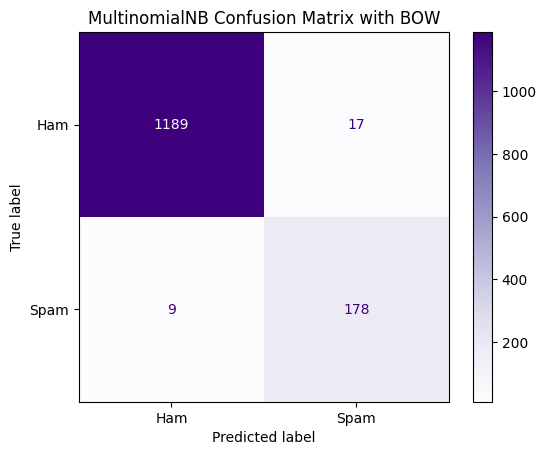

In [64]:
# Transform data
X_train_bow = bow_vect.fit_transform(X_train)
X_test_bow = bow_vect.transform(X_test)

# Let's use it directly, without grid search nor cross validation
mnb_clf = MultinomialNB()
mnb_clf.fit(X_train_bow, y_train)

mnb_pred = mnb_clf.predict(X_test_bow)
print(classification_report(y_test, mnb_pred, target_names=['ham', 'spam']))

mnb_conf_mtx = confusion_matrix(y_test, mnb_pred)
mnb_conf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=mnb_conf_mtx,
                                           display_labels=labels)
mnb_conf_mtx_disp.plot(cmap=plt.cm.Purples)
plt.title('MultinomialNB Confusion Matrix with BOW')
plt.show()

Even without making any parameters searching this model outperformed the other two regarding to *recall* making it suitable when detecting spam is more important than avoiding false positives. It has more misclassified ham messages (false positives), but the difference is not too high, though.



---

